# AIM
- Explore at what time of the day were sleep stages outputted?

In [2]:
import os
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.dates
import matplotlib.patches
import datetime as dt
import feather 
import random 
import ast

# custom modules
from import_data import *
from clean_data import *
from mappings import *
from plotting import *

%matplotlib inline
# import matplotlib.pylab as plt
from matplotlib import pyplot as plt

# from tsfresh import extract_features, extract_relevant_features, select_features
# from tsfresh.utilities.dataframe_functions import impute
# from tsfresh.feature_extraction import ComprehensiveFCParameters

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
pd.options.mode.chained_assignment = None

### autoreload external modules after saving changes to disk
%reload_ext autoreload
%autoreload 2

# Import data

In [4]:
proj_dir = Path('.') / '..' / '..'
source_data_dir = proj_dir/'data'/'source'
clean_data_dir =  proj_dir/'data'/'clean'
viz_dir = proj_dir/'viz'
_, _, metadata = import_data(source_data_dir)

- Load from disk

In [5]:
timeseries = pd.read_feather(clean_data_dir/'slps_timeseries.ftr')
intervals = pd.read_feather(clean_data_dir/'slps_interval_clean.ftr')

- Check dates

duration
pid                                  start_date           
007751c5-d7ad-4bec-a58f-abf32500e2ae 2019-11-04  15.383333
0157930f-10f7-4d5f-9575-a65efbd1d505 2019-12-02  16.108333
03d596f1-cf28-4204-a4c0-f2c08a3fe00b 2019-12-20  15.508333
04f2abf1-8fc5-49b6-8786-3def833f083d 2020-01-13  15.391667
                                     2020-01-17  15.100000
...                                                    ...
ee7bf346-039d-4efb-aa72-de3dbebcf823 2019-11-21  15.233333
                                     2019-12-02  18.808333
                                     2020-01-20  17.650000
ef3c8d02-f441-4aa5-ace1-69c2e863ebec 2019-03-17  17.308333
f4589eca-0e47-4bde-879e-f6b04c769c2b 2019-02-16  15.808333

[248 rows x 1 columns]

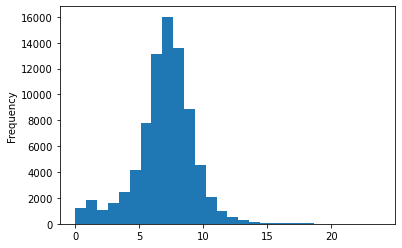

In [93]:
intv_duration = (intervals
    # .loc[intervals['pid'].isin(pids_select)]
    .loc[~(intervals['stages']=='AWAKE')]
    .groupby(['pid','start_date'])
    .agg(duration=('duration', np.sum))
)
intv_duration['duration'] = intv_duration['duration'] / 3600

intv_duration['duration'].plot.hist(bins=28);

intv_duration.loc[intv_duration['duration']>15]

- Select 3 patients (for now)

In [6]:
with open(clean_data_dir/'pid_without_dup.txt','r') as f:
   pid_without_dup = ast.literal_eval(f.read())

In [7]:
pid_balance = set(['03d596f1-cf28-4204-a4c0-f2c08a3fe00b',
       '24f82ff8-f2f5-448c-920e-a31d7bfb532f',
       '3408c15c-48b3-4742-a47c-83cac676a66a',
       '39635a7e-041f-497a-8768-2a4010840d9a',
       '403e104c-3b9e-402b-8f23-86dd4e99031f',
       '49a29158-e258-4949-bb1e-ee4292ed5243',
       '52dac003-4f24-486d-a8f6-15f3184e0cf5',
       '53a90883-4667-42f1-88ce-f6645f13626f',
       '56372890-8d43-40f6-985e-6ba276ef2af3',
       '57ad2c8f-d0ac-48f5-95a9-ef037b247d7b',
       '66ead137-75c1-45b7-91c2-e1e47a095ae4',
       '89d723a3-eb86-413e-b94b-c187c11abbeb',
       '97761b89-7419-45d5-9716-179fd9a71244',
       '9ec31ef3-94dd-4046-9283-aaed9d642c0a',
       'a5692178-3c90-4a7d-b0a5-f3ce6c5e368b',
       'a98e55ea-a2da-45f7-ac98-7484e82ec368',
       'aa69cde9-b36f-408c-9990-f4e5ffaaf6c3',
       'bb1eaf9d-ee98-42e4-9da5-0515767ca48c',
       'bbc4315f-dd12-432f-ad96-9fb66aa02832',
       'd0ee4138-d358-4ce6-bca5-ee5701f50378',
       'd3ba5d0d-6d18-4663-a95e-8ac9d0cdf282',
       'df96db2a-67cf-4ba8-bda1-25ea23ad6f71',
       'e4456f61-48eb-409c-bbc0-d2b3f3c90c80',
       'eb96d708-07f1-4a9a-a963-37eed19a8555',
       'f00896fc-9b8c-49ed-8083-501c46ad4234'])

In [14]:
pid_allowlist = list(pid_balance.union(pid_without_dup))
print(f'{len(pid_allowlist)=}')


len(pid_allowlist)=344


In [17]:
N_PID_SELECT = 3
random.seed(123)
pids_select = random.choices(pid_allowlist, k=N_PID_SELECT)
intv = intervals.loc[intervals['pid'].isin(pids_select)]
ts = explode2ts(intv)
tsm = pd.merge(intv, ts, on='intervalID')

In [19]:
# number of observed intervals per PID
intv.value_counts('pid')

pid
85cb77b2-8455-4502-8a92-9375934dba4d    2597
d69c28ae-cb9e-4505-a002-debf2c54b72d    2439
3d6a4d93-ec5f-4c58-8eea-2fdc46948a60     140
dtype: int64

In [23]:
# number of observed timepoints per PID
tsm.value_counts('pid')

pid
85cb77b2-8455-4502-8a92-9375934dba4d    97068
d69c28ae-cb9e-4505-a002-debf2c54b72d    91336
3d6a4d93-ec5f-4c58-8eea-2fdc46948a60     5254
dtype: int64

- Date distribution

- Getting the first and last times of the day

In [ ]:
tsm_first = tsm.groupby(['pid', 'start_date']).head(1)
tsm_end = tsm.groupby(['pid', 'start_date']).tail(1)

<ipython-input-22-5b6292430c53>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


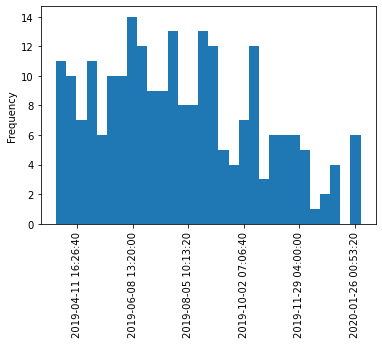

In [22]:
## plot start time distribution
fig, ax = plt.subplots()
tsm_first['start'].astype(np.int64).plot.hist(ax=ax, bins=30);
labels = ax.get_xticks().tolist()
labels = pd.to_datetime(labels)
ax.set_xticklabels(labels, rotation=90)
plt.show();

- Stage plotting

In [64]:
NROW = 200

plotdf = intervals.iloc[0:NROW]
plotdf['starttime'] = plotdf['start'].dt.time.apply(time2datetime).astype(np.int64)
plotdf['endtime'] = plotdf['end'].dt.time.apply(time2datetime).astype(np.int64)

In [65]:
# remove intervals that cross to the other day
plotdf = plotdf.loc[(plotdf['start_date'] == plotdf['end'].dt.date)]

<ipython-input-66-90dfbae7786d>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)
<ipython-input-66-90dfbae7786d>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


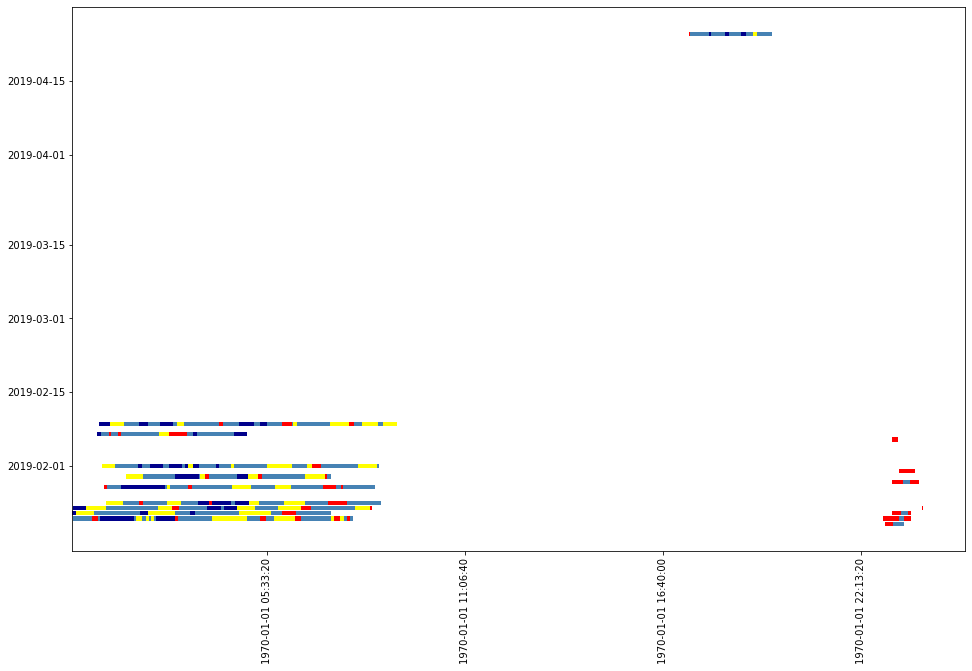

In [66]:
c_dict = {'AWAKE': 'red', 'DEEP': 'darkblue',
                  'LIGHT': 'steelblue', 'REM': 'yellow'}
color=list(plotdf['stages'].map(c_dict))
fig, ax = plt.subplots(1, figsize=(16, 10))

ax.barh(
    y=plotdf['start_date'],
    width=plotdf['endtime'] - plotdf['starttime'],
    left=plotdf['starttime'],
    color=color
)

labels = ax.get_xticks().tolist()
labels = pd.to_datetime(labels)
ax.set_xticklabels(labels, rotation=90)
fig.show();

# y_min = plotdf['start_date'].min()
# y_max = plotdf['start_date'].max() + dt.timedelta(days=1)
# x_max = plotdf['end'].max()
# x_min = plotdf['start'].min()

# ax.set_xlim(x_min, x_max)
# ax.set_ylim(y_min, y_max)
# plt.gca().invert_yaxis()
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=60))
# fig.show();